In [109]:
] activate .

  Activating new project at `~/.julia/dev/HJB/examples`


In [110]:
using Revise, BenchmarkTools

In [111]:
] st

Status `~/.julia/dev/HJB/examples/Project.toml` (empty project)


In [112]:
Threads.nthreads()

16

In [113]:
using LinearAlgebra, StaticArrays, Plots, ForwardDiff

In [114]:
include("../src/HJB.jl")

Main.HJB

In [155]:
# create the grid
x1s = range(-1.0, 2.0, length=256)
x2s = range(-1.0, 2.0, length=256)

grid = HJB.Grid((x1s, x2s))

Main.HJB.Grid{2, Float64}((-1.0, -1.0), (0.011764705882352941, 0.011764705882352941), (256, 256))

In [156]:
function plot_grid!(data, grid::HJB.Grid{2, F}) where {F}
    # for now only supports plotting 2 dimensional problems

    x1s = HJB.get_axes(grid, 1)
    x2s = HJB.get_axes(grid, 2)

    heatmap!(x1s, x2s, data')

end

plot_grid! (generic function with 2 methods)

In [157]:
# define the dynamics
function f(t, x, u)
    return @SVector [x[2], u[1]]
end

f (generic function with 1 method)

In [178]:
# define the Hamiltonian
function H(t, x, V, DxV, params)
    # u1 = @SVector [1.0]
    # u2 = @SVector [-1.0]

    # H1 = DxV' * f(t, x, u1)
    # H2 = DxV' * f(t, x, u2)

    # γ = 0

    # return min(0, max(H1, H2) + γ*V)

    u2 = @SVector [-1.0]
    H2 = DxV' * f(t, x, u2)
    γ = 0.5
    
    return min(0, H2 + γ*V)
end

H (generic function with 1 method)

In [179]:
# define the constraint function
function l(x)
    return 1.5 - x[1]
    
    # maxX = 1.5 - x[1]
    # maxV = 1.5 - x[2]
    
    # return min(maxX, maxV)

    # minV = x[2] + 0.5

    # if x[2] > 1.5
    #     return 1.5 - x[2]
    # else
    #     return maxX
    # end
    
    # return min(maxX, maxV)
    # # return min(maxV, minV)
    
    
end

l (generic function with 1 method)

In [180]:
function max_DpH(t, x)

    # should return max( abs( f(t, x, u2))  )
    # f(t, x, u) = @SVector [x[2], u[1]]
    # f(t, x, u) = [x[2], 0] + [0, u[1]]
    # ie. fx(t, x) = [x[2], 0]
    #     gx(t, x) = [0, 1]
    # so the dissipation coefficients by (25) of ToolboxLS are
    # \alpha_j(x) = | fx(t, x)_j |  + sum_{i=1}^{m} |gx_{ji}(t, x)| U_i
    # where m is the number of control inputs

    α = @SVector [abs(x[2]), 1.0]
    # α = @SVector [2, 1.]
    # α = @SVector [ 20, 10.] 
    # α = @SVector [ 0.2, 0.1 ] 
    
    return α
end

max_DpH (generic function with 1 method)

In [181]:
# construct the HJB problem
tspan = (0.0, 2.0)
prob = HJB.HJBProblem(H, l, tspan)

Main.HJB.HJBProblem{Float64, typeof(H), typeof(l), Nothing}(H, l, (0.0, 2.0), nothing)

In [182]:
VF = HJB.allocate_grid(Float64, grid, l)
dV = similar(VF);

In [183]:
timeMethod = HJB.LaxFriedrichs(max_DpH)

Main.HJB.LaxFriedrichs(max_DpH)

In [184]:
RHS! = HJB.get_ODE_RHS(prob, grid, timeMethod,HJB.WENO())

(::Main.HJB.var"#RHS!#30"{Main.HJB.Grid{2, Float64}, Main.HJB.WENO, Main.HJB.var"#numH#36"{Main.HJB.HJBProblem{Float64, typeof(H), typeof(l), Nothing}, typeof(max_DpH)}}) (generic function with 1 method)

In [213]:
# solve the ODE
# gradMethod = HJB.Simple()
gradMethod = HJB.WENO()
timeMethod = HJB.Direct()
# timeMethod = HJB.LaxFriedrichs(max_DpH)
# alg=HJB.DiffEq.Euler()
# alg = HJB.DiffEq.RK4()
alg=HJB.DiffEq.Vern7()
@time sol = HJB.solve_MOL(prob, grid; gradMethod=gradMethod, timeMethod=timeMethod,  alg=alg, dt=0.1e-3, dtmax=2e-3, reltol=1e-8, abstol=1e-8)

265.792387 seconds (7.81 M allocations: 39.396 GiB, 0.85% gc time, 0.86% compilation time)


Main.HJB.HJBSolution_MOL{Main.HJB.HJBProblem{Float64, typeof(H), typeof(l), Nothing}, Main.HJB.Grid{2, Float64}, SciMLBase.ODESolution{Float64, 3, Vector{Matrix{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{Float64}}}, SciMLBase.ODEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, Nothing, SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, Main.HJB.var"#RHS!#26"{Main.HJB.HJBProblem{Float64, typeof(H), typeof(l), Nothing}, Main.HJB.Grid{2, Float64}, Main.HJB.WENO}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, OrdinaryDiffEq.Vern7{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, Main.HJB.

In [214]:
sol.sol.alg

Vern7(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true,)

In [215]:
sol.sol.t

7201-element Vector{Float64}:
 2.0
 1.9999
 1.9997756038305747
 1.999465662252615
 1.9987597777254638
 1.9977861053433974
 1.9971022832953544
 1.996310734604727
 1.9954925978326876
 1.994633765049803
 1.9937095730305237
 1.9927325459939855
 1.9916733271047422
 ⋮
 0.0010023753152429548
 0.000910156911062541
 0.0008135343450910218
 0.000719907453829594
 0.0006274284709625207
 0.0005393849019489074
 0.00045360771371045426
 0.0003641352024298332
 0.00026886698169445325
 0.0001766166963030606
 8.249066947120154e-5
 0.0

In [226]:
# @time sol = HJB.solve_MOL(prob, grid; gradMethod=HJB.Simple(), timeMethod=timeMethod, dtmax=1e-4, reltol=1e-6, abstol=1e-6)

In [227]:
sol.sol.alg

Vern7(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true,)

In [228]:
sol.sol

retcode: Success
Interpolation: specialized 7th order lazy interpolation
t: 7201-element Vector{Float64}:
 2.0
 1.9999
 1.9997756038305747
 1.999465662252615
 1.9987597777254638
 1.9977861053433974
 1.9971022832953544
 1.996310734604727
 1.9954925978326876
 1.994633765049803
 1.9937095730305237
 1.9927325459939855
 1.9916733271047422
 ⋮
 0.0010023753152429548
 0.000910156911062541
 0.0008135343450910218
 0.000719907453829594
 0.0006274284709625207
 0.0005393849019489074
 0.00045360771371045426
 0.0003641352024298332
 0.00026886698169445325
 0.0001766166963030606
 8.249066947120154e-5
 0.0
u: 7201-element Vector{Matrix{Float64}}:
 [2.5 2.5 … 2.5 2.5; 2.488235294117647 2.488235294117647 … 2.488235294117647 2.488235294117647; … ; -0.4882352941176471 -0.4882352941176471 … -0.4882352941176471 -0.4882352941176471; -0.5 -0.5 … -0.5 -0.5]
 [2.5 2.5 … 2.5 2.5; 2.488235294117647 2.488235294117647 … 2.488160771406981 2.4881595901495634; … ; -0.4882352941176471 -0.4882352941176471 … -0.48845838874

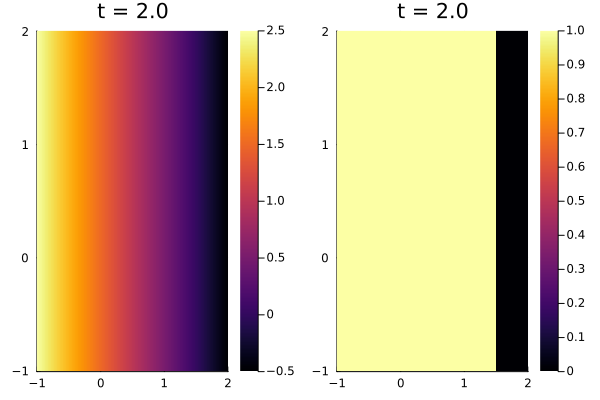

In [229]:
ind = 1 # length(sol.sol.t)

p1 = plot()
plot_grid!(sol.sol.u[ind], grid)
title!("t = $(sol.sol.t[ind])")

p2 = plot()
plot_grid!(sol.sol.u[ind] .>= 0.0, grid)
title!("t = $(sol.sol.t[ind])")

plot!(p1, p2)

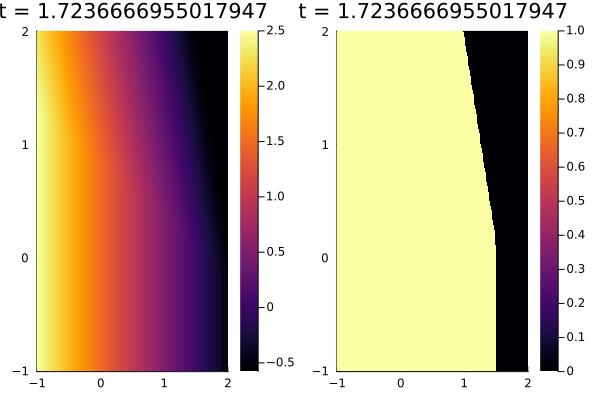

In [230]:
ind = 150 # length(sol.sol.t)

p1 = plot()
plot_grid!(sol.sol.u[ind], grid)
title!("t = $(sol.sol.t[ind])")

p2 = plot()
plot_grid!(sol.sol.u[ind] .>= 0.0, grid)
title!("t = $(sol.sol.t[ind])")

plot!(p1, p2)


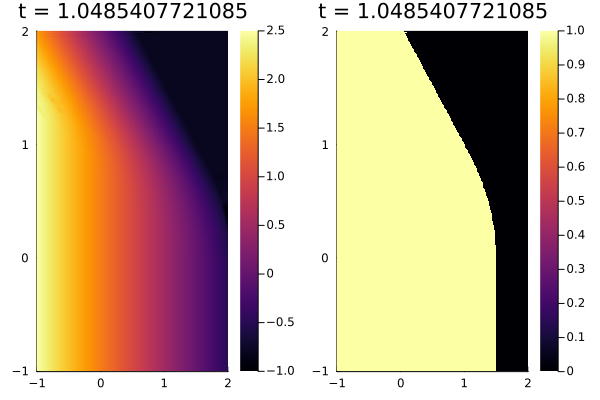

In [231]:
ind = round(Int, (1/10) * length(sol.sol.t))

p1 = plot()
plot_grid!(sol.sol.u[ind], grid)
title!("t = $(sol.sol.t[ind])")

p2 = plot()
plot_grid!(sol.sol.u[ind] .>= 0.0, grid)
title!("t = $(sol.sol.t[ind])")

plot!(p1, p2)

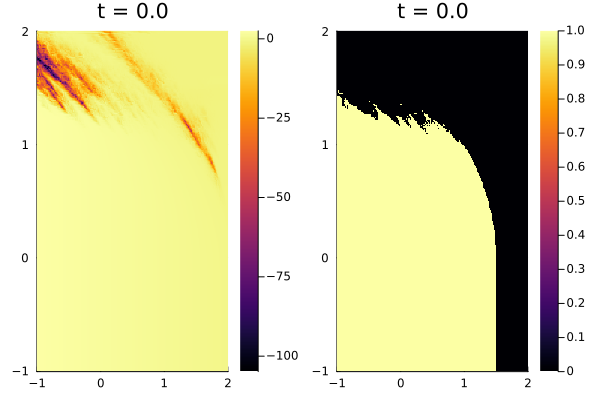

In [232]:
ind =  length(sol.sol.t)

p1 = plot()
plot_grid!(sol.sol.u[ind], grid)
title!("t = $(sol.sol.t[ind])")

p2 = plot()
plot_grid!(sol.sol.u[ind] .>= 0.0, grid)
title!("t = $(sol.sol.t[ind])")

plot!(p1, p2)

In [223]:
maximum(-diff(sol.sol.t))

0.0020000000000000018

In [224]:
minimum(-diff(sol.sol.t))

7.804267298348747e-5

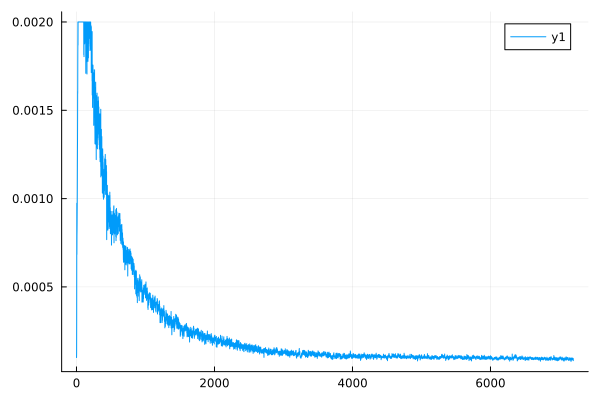

In [225]:
plot(-diff(sol.sol.t))

In [144]:
# # solve the ODE
# @time sol = HJB.solve_MOL(prob, grid; gradMethod=HJB.Simple(), timeMethod=HJB.Direct(), alg=HJB.DiffEq.Euler(), dt=1e-3, reltol=1e-8, abstol=1e-8)

LoadError: InterruptException:

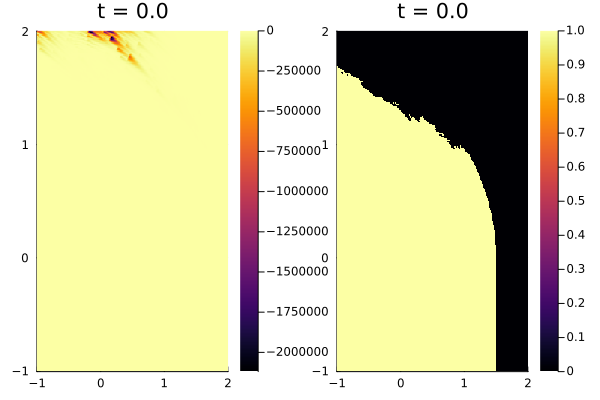

In [145]:
ind = round(Int, (10/10) * length(sol.sol.t))

p1 = plot()
plot_grid!(sol.sol.u[ind], grid)
title!("t = $(sol.sol.t[ind])")

p2 = plot()
plot_grid!(sol.sol.u[ind] .>= 0.0, grid)
title!("t = $(sol.sol.t[ind])")

plot!(p1, p2)

In [142]:
# solve the ODE
@time sol = HJB.solve_MOL(prob, grid; gradMethod=HJB.WENO(), timeMethod=HJB.Direct(), alg=HJB.DiffEq.Euler(), dt=1e-4, reltol=1e-8, abstol=1e-8)

LoadError: InterruptException:

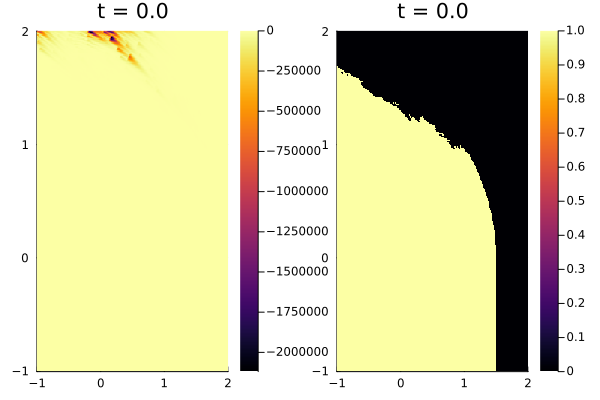

In [143]:
ind = round(Int, (10/10) * length(sol.sol.t))

p1 = plot()
plot_grid!(sol.sol.u[ind], grid)
title!("t = $(sol.sol.t[ind])")

p2 = plot()
plot_grid!(sol.sol.u[ind] .>= 0.0, grid)
title!("t = $(sol.sol.t[ind])")

plot!(p1, p2)